# Axisymmetric formulation for elastic structures of revolution

In this numerical tour, we will deal with axisymmetric problems of elastic solids. We will consider a solid of revolution around a fixed axis $(Oz)$, the loading, boundary conditions and material properties being also invariant with respect to a rotation along the symmetry axis. The solid cross-section in a plane $\theta=\text{cst}$ will be represented by a two-dimensional domain $\omega$ for which the first spatial variable (`x[0]` in FEniCS) will represent the radial coordinate $r$ whereas the second spatial variable will denote the axial variable $z$.

## Problem position

We will investigate here the case of a hollow hemisphere of inner (resp. outer) radius $R_i$ (resp. $R_e$). Due to the revolution symmetry, the 2D cross-section corresponds to a quarter of a hollow cylinder.

<IPython.core.display.Javascript object>


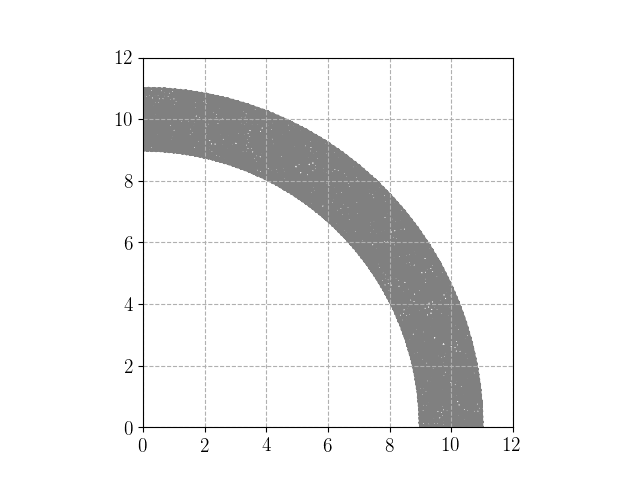

In [9]:
from __future__ import print_function
from dolfin import *
from mshr import *
import matplotlib.pyplot as plt
%matplotlib notebook

Re = 11.
Ri = 9.
rect = Rectangle(Point(0., 0.), Point(Re, Re))
domain = Circle(Point(0., 0.), Re, 100) - Circle(Point(0., 0.), Ri, 100)
domain = domain - Rectangle(Point(0., -Re), Point(-Re, Re)) \
                - Rectangle(Point(0., 0.), Point(Re, -Re))

mesh = generate_mesh(domain, 40)
plot(mesh)

class Bottom(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0) and on_boundary
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0) and on_boundary
class Outer(SubDomain):
    def inside(self, x, on_boundary):
        return near(sqrt(x[0]**2+x[1]**2), Re, 1e-1) and on_boundary  
    
facets = MeshFunction("size_t", mesh, 1)
facets.set_all(0)
Bottom().mark(facets, 1)
Left().mark(facets, 2)
Outer().mark(facets, 3)
ds = Measure("ds", subdomain_data=facets)


## Definition of axisymmetric strains

For axisymmetric conditions, the unkown displacement field is of the form:

$$\begin{equation}
\boldsymbol{u} = u_r(r,z)\boldsymbol{e}_r + u_z(r,z)\boldsymbol{e}_z
\end{equation}$$

As a result, we will work with a standard VectorFunctionSpace of dimension 2. The associated strain components are however given by:

$$\begin{equation}
\boldsymbol{\varepsilon} = \begin{bmatrix} \partial_r u_r & 0 & (\partial_z u_r + \partial_r u_z)/2 \\ 
0 & u_r/r & 0 \\
(\partial_z u_r + \partial_r u_z)/2 & 0 & \partial_z u_z\end{bmatrix}_{(\boldsymbol{e}_r,\boldsymbol{e}_\theta,\boldsymbol{e}_z)}
\end{equation}$$

The previous relation involves explicitly the radial variable $r$, which can be obtained from the SpatialCoordinate `x[0]`, the strain-displacement relation is then defined explicitly in the `eps` function.

> **Note**: we could also express the strain components in the form of a vector of size 4 in alternative of the 3D tensor representation implemented below.

In [10]:
x = SpatialCoordinate(mesh)

def eps(v):
    return sym(as_tensor([[v[0].dx(0), 0, v[0].dx(1)],
                          [0, v[0]/x[0], 0],
                          [v[1].dx(0), 0, v[1].dx(1)]]))

E = Constant(1e5)
nu = Constant(0.3)
mu = E/2/(1+nu)
lmbda = E*nu/(1+nu)/(1-2*nu)
def sigma(v):
    return lmbda*tr(eps(v))*Identity(3) + 2.0*mu*eps(v)

## Resolution

The rest of the formulation is similar to the 2D elastic case with a small difference in the integration measure. Indeed, the virtual work principle reads as:

$$\begin{equation}
 \text{Find } \boldsymbol{u}\in V \text{ s.t. } \int_{\Omega}
 \boldsymbol{\sigma}(\boldsymbol{u}):\boldsymbol{\varepsilon}(\boldsymbol{v}) d\Omega
 = \int_{\partial \Omega_T} \boldsymbol{T}\cdot\boldsymbol{v}  dS \quad \forall\boldsymbol{v} \in V
 \end{equation}$$
 
where $\boldsymbol{T}$ is the imposed traction on some part $\partial \Omega_T$ of the domain boundary.

In axisymmetric conditions, the full 3D domain $\Omega$ can be decomposed as $\Omega = \omega \times [0;2\pi]$ where the interval represents the $\theta$ variable. The integration measures therefore reduce to $d\Omega = d\omega\cdot(rd\theta)$ and $dS = ds\cdot(rd\theta)$ where $dS$ is the surface integration measure on the 3D domain $\Omega$ and $ds$ its counterpart on the cross-section boundary $\partial \omega$. Exploiting the invariance of all fields with respect to $\theta$, the previous virtual work principle is reformulated on the cross-section only as follows:

$$\begin{equation}
 \text{Find } \boldsymbol{u}\in V \text{ s.t. } \int_{\omega}
 \boldsymbol{\sigma}(\boldsymbol{u}):\boldsymbol{\varepsilon}(\boldsymbol{v}) rd\omega
 = \int_{\partial \omega_T} \boldsymbol{T}\cdot\boldsymbol{v}  rds \quad \forall\boldsymbol{v} \in V
 \end{equation}$$
 
where the $2\pi$ constants arising from the integration on $\theta$ have been cancelled on both sides. As a result, the bilinear and linear form are similar to the plane 2D case with the exception of the additional $r$ term in the integration measures.

The final formulation is therefore pretty straightforward. Since a uniform pressure loading is applied on the outer boundary, we will also need the exterior normal vector to define the work of external forces form.

In [11]:
n = FacetNormal(mesh)
p = Constant(10.)

V = VectorFunctionSpace(mesh, 'CG', degree=2)
du = TrialFunction(V)
u_ = TestFunction(V)
a = inner(sigma(du), eps(u_))*x[0]*dx
l = inner(-p*n, u_)*x[0]*ds(3)

u = Function(V, name="Displacement")

First, smooth contact conditions are assumed on both $r=0$ (`Left`) and $z=0$ (`Bottom`) boundaries. For this specific case, the solution corresponds to the classical hollow sphere under external pressure with a purely radial displacement:

$$\begin{equation}
u_r(r) = -\dfrac{R_e^3}{R_e^3-R_i^3}\left((1 − 2\nu)r + (1 + \nu)\dfrac{R_i^3}{2r^2}\right)\dfrac{p}{E},
\quad u_z=0
\end{equation}$$

In [12]:
bcs = [DirichletBC(V.sub(1), Constant(0), facets, 1),
       DirichletBC(V.sub(0), Constant(0), facets, 2)]
solve(a == l, u, bcs)
print("Inwards radial displacement at (r=Re, theta=0): \
{:1.7f} (FE) {:1.7f} (Exact)".format(-u(Re, 0.)[0], float(Re**3/(Re**3-Ri**3)*((1-2*nu)*Re+(1+nu)*Ri**3/2/Re**2)*p/E)))
print("Inwards radial displacement at (r=Ri, theta=0): \
{:1.7f} (FE) {:1.7f} (Exact)".format(-u(Ri, 0.)[0], float(Re**3/(Re**3-Ri**3)*((1-2*nu)*Ri+(1+nu)*Ri/2)*p/E)))

Inwards radial displacement at (r=Re, theta=0): 0.0018375 (FE) 0.0018387 (Exact)
Inwards radial displacement at (r=Ri, theta=0): 0.0020879 (FE) 0.0020894 (Exact)


<IPython.core.display.Javascript object>


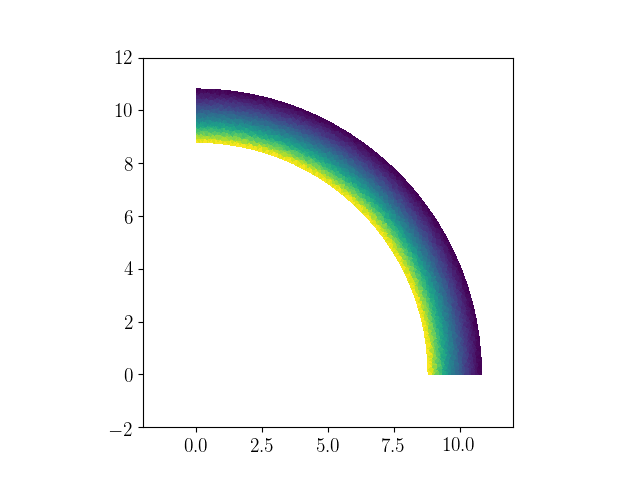

In [13]:
plt.figure()
plot(100*u, mode="displacement")
plt.show()

The second loading case corresponds to a fully clamped condition on $z=0$, the vertical boundary remaining in smooth contact.

<IPython.core.display.Javascript object>


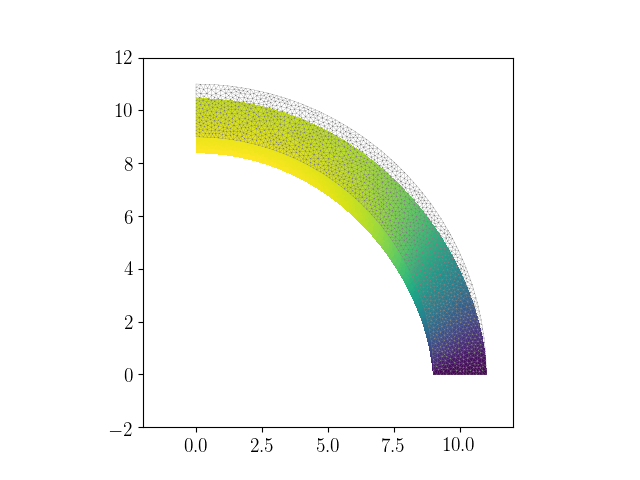

In [14]:
bcs = [DirichletBC(V, Constant((0., 0.)), facets, 1),
       DirichletBC(V.sub(0), Constant(0), facets, 2)]
solve(a == l, u, bcs)
plt.figure()
plot(mesh, linewidth=0.2)
plot(200*u, mode="displacement")
plt.show()